<a href="https://colab.research.google.com/github/soumick1/Tabular-data-extraction-from-images-OCR-/blob/main/image_to_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytesseract
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract

In [ ]:
'''img = cv2.imread(r'/content/page_40.PNG')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2.imwrite('/content/page_40.PNG', gray)'''

"img = cv2.imread(r'/content/page_40.PNG')\ngray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)\ncv2.imwrite('/content/page_40.PNG', gray)"

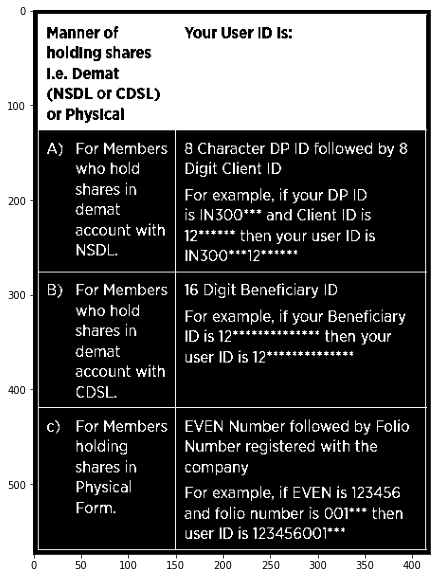

In [ ]:
#read your file
plt.figure(figsize=(12,10))
file=r'/content/page_40.PNG'
img = cv2.imread(file,0)
#gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#plt.imshow(gray_image)
img.shape

#thresholding the image to a binary image
thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)

#inverting the image 
img_bin = 255-img_bin
cv2.imwrite('/Users/YOURPATH/cv_inverted.png',img_bin)

#Plotting the image to see the output
plotting = plt.imshow(img_bin,cmap='gray')
plt.show()

In [ ]:
# Length(width) of kernel as 100th of total width
kernel_len = np.array(img).shape[1]//100

# Defining a vertical kernel to detect all vertical lines of image 
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))

# Defining a horizontal kernel to detect all horizontal lines of image
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))

# A kernel of 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

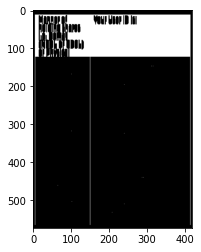

In [ ]:
#Use vertical kernel to detect and save the vertical lines in a jpg
image_1 = cv2.erode(img_bin, ver_kernel, iterations=4)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=4)
cv2.imwrite("/content/vertical.jpg",vertical_lines)

#Plot the generated image
plotting = plt.imshow(image_1,cmap='gray')
plt.show()

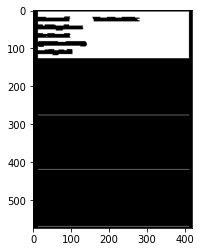

In [ ]:
#Use horizontal kernel to detect and save the horizontal lines in a jpg
image_2 = cv2.erode(img_bin, hor_kernel, iterations=4)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=4)
cv2.imwrite("/content/horizontal.jpg",horizontal_lines)

#Plot the generated image
plotting = plt.imshow(image_2,cmap='gray')
plt.show()

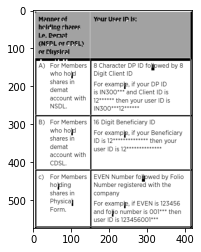

In [ ]:
# Combine horizontal and vertical lines in a new third image, with both having same weight.
img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)

#Eroding and thesholding the image
img_vh = cv2.erode(~img_vh, kernel, iterations=3)
thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cv2.imwrite("/content/img_vh.jpg", img_vh)
bitxor = cv2.bitwise_xor(img,img_vh)
bitnot = cv2.bitwise_not(bitxor)

#Plotting the generated image
plotting = plt.imshow(bitnot,cmap='gray')
plt.show()

In [ ]:
# Detect contours for following box detection
contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
      reverse = True

    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
      i = 1

    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

In [ ]:
# Sort all the contours by top to bottom.
contours, boundingBoxes = sort_contours(contours, method='top-to-bottom')

In [ ]:
#Creating a list of heights for all detected boxes
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]

#Get mean of heights
mean = np.mean(heights)

419 574
7 5
1 2
2 3
3 3
4 3
3 3
6 3
5 3
4 3
3 3
1 1
3 7
1 3
5 7
6 6
3 3
5 3
3 3
6 5
4 7
5 4
3 3
1 1
3 4
2 3
5 3
3 3
7 9
2 4
5 5
7 5
6 5
5 5
2 3
3 5
2 3
5 3
2 6
6 7
5 7
4 3
4 3
3 3
1 146
141 146
260 142
10 18
6 18
6 18
1 139
260 139
141 139
6 18
6 18
1 146
260 146
141 146
10 18
6 18
6 18
6 18
6 18
1 1
260 1
141 1


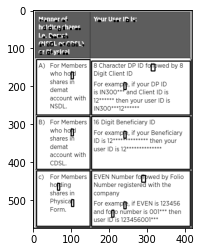

In [ ]:
#Create list box to store all boxes in  
box = []

# Get position (x,y), width and height for every contour and show the contour on image
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    print(w,h)
    if (w<1000 and h<700):
        image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        box.append([x,y,w,h])
plotting = plt.imshow(image,cmap='gray')
plt.show()

In [ ]:
#Creating two lists to define row and column in which cell is located
row=[]
column=[]
j=0

#Sorting the boxes to their respective row and column
for i in range(len(box)):
    if(i==0):
        column.append(box[i])
        previous=box[i]
    else:
        if(box[i][1]<=previous[1]+mean/2):
            column.append(box[i])
            previous=box[i]
            if(i==len(box)-1):
                row.append(column)
        else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])
print(column)
print(row)

[[418, 573, 1, 1], [154, 573, 260, 1], [9, 573, 141, 1]]
[[[0, 0, 419, 574]], [[245, 25, 7, 5], [89, 25, 1, 2], [18, 25, 2, 3], [265, 27, 3, 3], [221, 27, 4, 3], [213, 27, 3, 3], [172, 27, 6, 3], [78, 27, 5, 3], [59, 27, 4, 3], [32, 27, 3, 3], [25, 27, 1, 1]], [[80, 44, 3, 7], [60, 44, 1, 3], [28, 44, 5, 7], [42, 45, 6, 6], [121, 48, 3, 3], [112, 48, 5, 3], [98, 48, 3, 3], [66, 49, 6, 5]], [[80, 66, 4, 7], [67, 66, 5, 4], [45, 66, 3, 3], [88, 68, 1, 1], [49, 69, 3, 4], [89, 70, 2, 3], [56, 70, 5, 3], [27, 70, 3, 3], [46, 85, 7, 9], [81, 87, 2, 4], [113, 89, 5, 5], [102, 89, 7, 5], [91, 89, 6, 5], [37, 89, 5, 5], [25, 89, 2, 3], [18, 90, 3, 5], [131, 91, 2, 3], [71, 91, 5, 3], [48, 107, 2, 6], [38, 109, 6, 7], [18, 109, 5, 7], [87, 113, 4, 3], [79, 113, 4, 3], [66, 113, 3, 3]], [[418, 130, 1, 146], [9, 130, 141, 146], [154, 134, 260, 142], [311, 142, 10, 18]], [[100, 163, 6, 18]], [[239, 191, 6, 18]], [[418, 280, 1, 139], [154, 280, 260, 139], [9, 280, 141, 139]], [[100, 313, 6, 18], [2

In [ ]:
#calculating maximum number of cells
countcol = 0
for i in range(len(row)):
    countcol = len(row[i])
    if countcol > countcol:
        countcol = countcol

In [ ]:
#Retrieving the center of each column
center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]
center=np.array(center)
center.sort()

In [ ]:
#Regarding the distance to the columns center, the boxes are arranged in respective order
finalboxes = []
for i in range(len(row)):
    lis=[]
    for k in range(countcol):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)

In [ ]:
#from every single image-based cell/box the strings are extracted via pytesseract and stored in a list
outer=[]
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner=''
        if(len(finalboxes[i][j])==0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2,   cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=0)
                erosion = cv2.erode(dilation, kernel,iterations=0)

                
                out = pytesseract.image_to_string(erosion)
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion, config='--psm 3')
                inner = inner +" "+ out
            outer.append(inner)

In [ ]:
#Creating a dataframe of the generated OCR list
arr = np.array(outer)

dataframe = pd.DataFrame(arr.reshape(len(row),countcol))
print(dataframe)
data = dataframe.style.set_properties(align="left")

#dataframe.to_csv('out.csv')

                                                    0  ...   2
0    A) For Members\nwho hoy\nshares in\ndemat\nac...  ...    
1                                               ...    
2                                      \n      ...    
3                        \n  \...  ...    
4    A) For Members\nwho hoy\nshares in\ndemat\nac...  ...   
5                                                     ...    
6                                                      ...    
7    B) For Members\nwho hoy\nshares in\ndemat\nac...  ...   
8                                                     ...    
9    c) For Members\nhoxing\nshares in\nPhysica]\n...  ...   
10                                                    ...    
11                                                    ...    
12                                                     ...    
13                                                    ...   

[14 rows x 3 columns]


In [ ]:
#dataframe.to_csv('out.csv')

In [ ]:
pool = []
for i in range(len(dataframe.columns)):
  if dataframe.iloc[0][i] == '' or str(dataframe.iloc[0][i]) == ' \x0c':
    print(dataframe.iloc[0][i])
    pool.append(i)
print(pool)
if len(pool)!= 0:
  dataframe = dataframe.drop(pool, axis=1)
dataframe

[]


,0,1,2
0,A) For Members\nwho hoy\nshares in\ndemat\nac...,,
1,,,
2,\n,,
3,\n \...,,
4,A) For Members\nwho hoy\nshares in\ndemat\nac...,8 Character DP ID fojjowed by 8\nDigit Client...,
5,,,
6,,,
7,B) For Members\nwho hoy\nshares in\ndemat\nac...,"16 Digit Beneficiary ID\n\nFor exampp, if you...",
8,,,
9,c) For Members\nhoxing\nshares in\nPhysica]\n...,EVEN Number fojjpwed by Folio\nNumber registe...,


In [ ]:
def func(m):
  s = str(m)
  if '\x0c' in s:
    s = ''.join(s.split('\x0c'))
  return s.strip()

for i in dataframe.columns:
  dataframe[i] = dataframe[i].apply(func)

In [ ]:
dataframe.to_csv('out.csv')

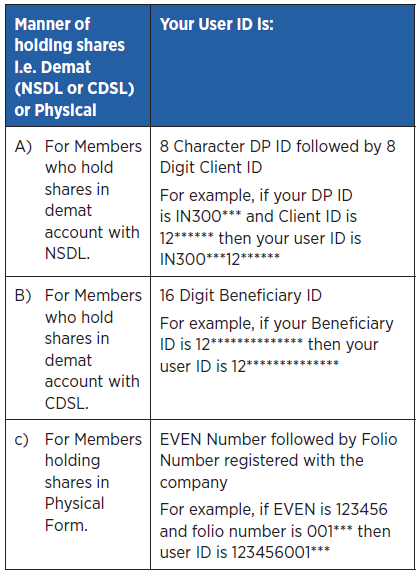

In [ ]:
from google.colab.patches import cv2_imshow
img = cv2.imread('/content/page_40.PNG')
cv2_imshow(img)

In [ ]:
img[-10][-10]

255

In [ ]:
dataframe.iloc[0][1]

''

In [ ]:
str(dataframe.iloc[0][1]).replace('\x0c', '')

''